# Recognize a face and produce a unique ID

The goal of this project is to read images from a capture location on disk and identify faces. When a face is detected a unique ID will be produced for that face.

This example uses Microsoft's cognative services to recognize a face and it's emotion. 

Then we just need to extract the faces from the image and apply a algorithm for generating a hash. This example uses relative distances from key points in the face. So the combonation of the relative distance between eyes and nose an produce a unique number that can be hashed.


# Setup a watch on the file system for new images
We can use a file system watcher to look for new images. That way any interface that can write images to the file system can interface with this algorithm. In my example I will be using a motion detection tool to detect motion and capture in image from the webcam interface and write it to the drop folder this algorithm is watching. The result will be processed by the algorithm. 

In [1]:
import sys
import time
import logging
import glob
from watchdog.observers import Observer
from watchdog.events import PatternMatchingEventHandler

In [2]:
path = '/images'
files = glob.glob(path + "/*.jpg")

class MyHandler(PatternMatchingEventHandler):
    patterns = ["*.jpg"]
    def on_created(self, event):
        global files
        files.append(event.src_path) # this will allays keep the global var files up to date
        #trigger processing of new file
        

In [3]:
event_handler = MyHandler()
observer = Observer()
observer.schedule(event_handler, path, recursive=True)
observer.start()

In [4]:
print(files)

['/images/evorie.jpg']


# Run image through MS Cognative services and identify faces found

In [5]:
import time 
import requests
import cv2
import operator
import numpy as np
import os

# Import library to display results
import matplotlib.pyplot as plt
%matplotlib inline 
# Display images within Jupyter

In [6]:
_url = 'https://api.projectoxford.ai/emotion/v1.0/recognize'
_key = os.environ['oxford_key'] #Here you have to paste your primary key
_maxNumRetries = 10

In [7]:
def processRequest( json, data, headers ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = None )

        if response.status_code == 429: 

            print("Message: %s" % ( response.json()['error']['message'] ))

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print('Error: failed after retrying!')
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print("Error code: %d" % ( response.status_code ))
            print("Message: %s" % ( response.json()['error']['message'] ))

        break
        
    return result

In [8]:
def renderResultOnImage( result, img ):
    
    """Display the obtained results onto the input image"""
    
    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                           (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                       color = (255,0,0), thickness = 5 )


    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        currEmotion = max(currFace['scores'].items(), key=operator.itemgetter(1))[0]


        textToWrite = "%s" % ( currEmotion )
        cv2.putText( img, textToWrite, (faceRectangle['left'],faceRectangle['top']-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1 )

[{'scores': {'contempt': 1.3045852e-05, 'sadness': 4.94498363e-06, 'neutral': 0.00408503925, 'anger': 0.000208841157, 'surprise': 0.992425561, 'fear': 0.000158077251, 'disgust': 0.000219768044, 'happiness': 0.00288469577}, 'faceRectangle': {'width': 191, 'height': 191, 'left': 300, 'top': 85}}]


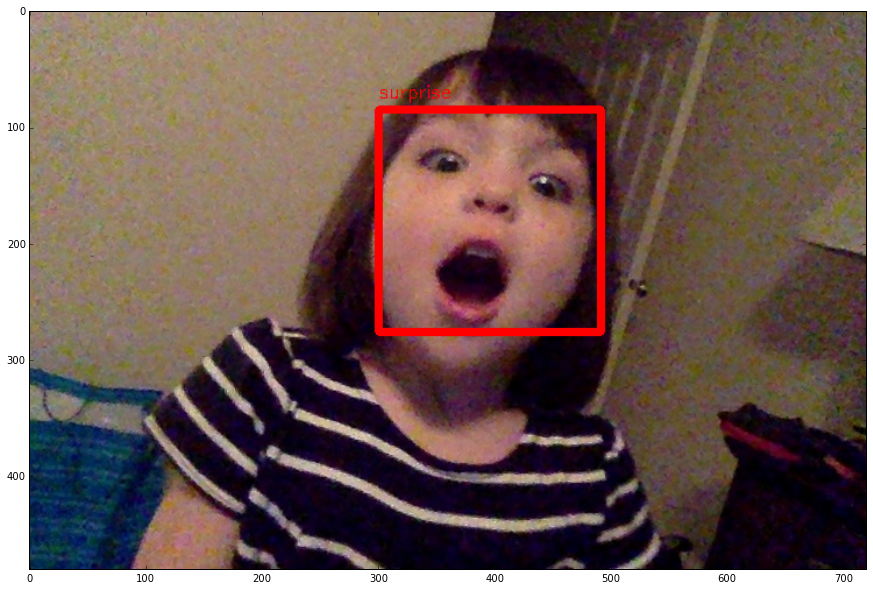

In [9]:
# Load raw image file into memory
pathToFileInDisk = r'/images/evorie.jpg'
with open( pathToFileInDisk, 'rb' ) as f:
    data = f.read()
    
headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/octet-stream'

json = None

result = processRequest( json, data, headers )
print(result)
# Load the original image from disk
data8uint = np.fromstring( data, np.uint8 ) # Convert string to an unsigned int array

img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )

renderResultOnImage( result, img )

ig, ax = plt.subplots(figsize=(15, 20))
ax.imshow( img )

# Use SIFT feature detection on the extracted face.

## Feature Detection is for corner identification
Using corner identification we might be able to detect common key points on faces that we can use for the hashing algorithm.

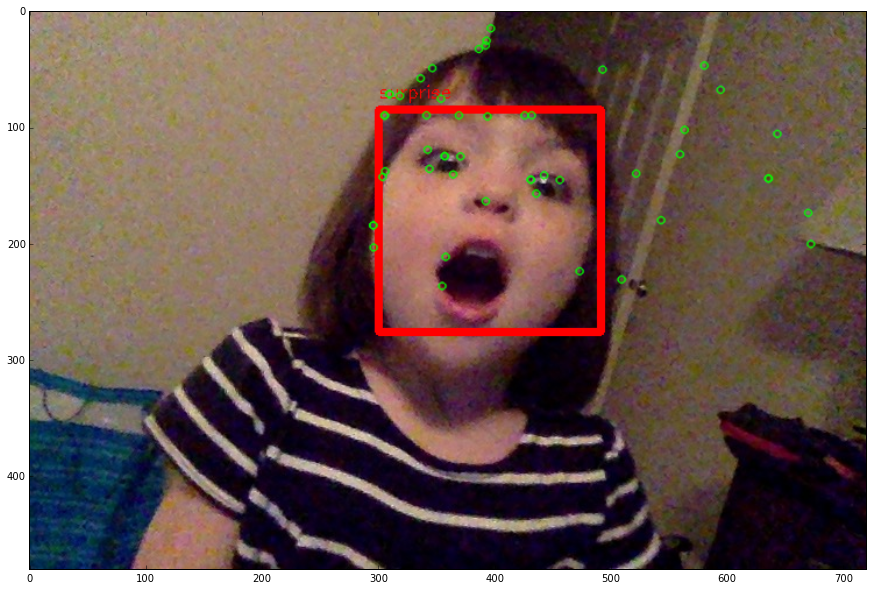

In [13]:

# opencv3 requires an output image, but we don't use it
dummy = np.zeros((1,1))

# Initiate STAR detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints with ORB
kp = sift.detect(img,None)

# compute the descriptors with ORB
kp, des = sift.compute(img, kp)

# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(img,kp[:50],dummy,color=(0,255,0),flags=0)

#plt.imshow(img),plt.show()
ig, ax = plt.subplots(figsize=(15, 20))
ax.imshow( img2 )

# reduce a image of a face to a recognized hash code
### Use KeyPoints to produce hash of image?
Not sure this is feasible. Key points need to be consistantly identified and their relative distances between them is what we would want to hash.
### Can we identify the same key points on an image?
Might need to do haar classifier to parts of the face then measure the distances between them.

For example the distance between two eyes in a face. 

# send a request to the color-wander service to use a given hash code
###TODO:
* Create a request URL that has the hash code embeded
* Create a restful interface that can take a hash code and update the currently rendered image.